In [2]:
from source.ion_channel import IonChannel
from source.patch_clamp import PatchClamp
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras



## Produce some data

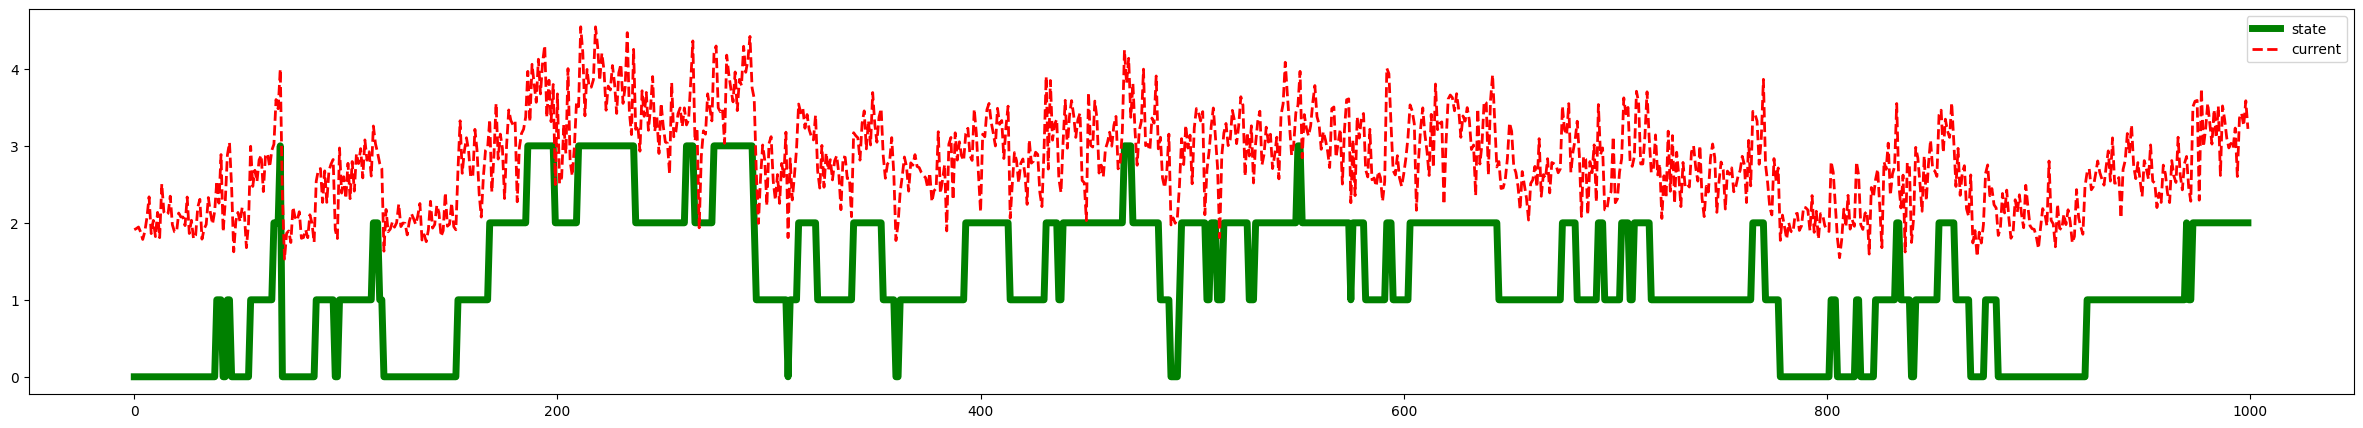

In [3]:
p = PatchClamp([IonChannel(1000), IonChannel(1000), IonChannel(1000)])
s = p.get_state()
c = p.get_current()

plt.figure(figsize=(30, 5))
plt.plot(s, color='green', label='state', linestyle='solid', linewidth=5)
plt.plot(c, color='red', label='current', linestyle='dashed', linewidth=2)
plt.legend()


In [7]:
X = []
y = []
for i in range(1500):
    patch_clamp = PatchClamp([IonChannel(1000), IonChannel(1000), IonChannel(1000)])
    normalized_X = (patch_clamp.X - np.min(patch_clamp.X)) / (np.max(patch_clamp.X) - np.min(patch_clamp.X))
    X.append(normalized_X)
    y.append(patch_clamp.y)

In [8]:
X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)

(1500, 1000)
(1500, 1000)


In [9]:
X_train = X[:1000]
y_train = y[:1000]
X_test = X[1000:]
y_test = y[1000:]

In [10]:
# prepare data for LSTM, X is 100 points and y is 1 point
def prepare_data(X, y, x_len=50, y_len=1, n_samples=1000):
    X_lstm = []
    y_lstm = []
    for i in range(n_samples):
        # randomly select a datapoint in X and y
        idx = np.random.randint(0, len(X) - x_len - y_len)
        # randomly select a point in X[idx] which its index is greater than x_len and smaller than len(X[idx]) - x_len
        y_index = np.random.randint(x_len, len(X[idx]) - x_len)
        y_lstm.append(y[idx][y_index:y_index + y_len])
        # x is the previous x_len points of y and x_len points after y, excluding y
        x_before = X[idx][y_index - x_len:y_index]
        x_after = X[idx][y_index + 1:y_index + x_len + 1]
        X_lstm.append(np.concatenate((x_before, x_after)))

    return np.array(X_lstm), np.array(y_lstm)


In [11]:
X_train_lstm, y_train_lstm = prepare_data(X_train, y_train)
X_test_lstm, y_test_lstm = prepare_data(X_test, y_test)

In [12]:
print(X_train_lstm.shape)
print(y_train_lstm.shape)

(1000, 100)
(1000, 1)


## Build a model

In [19]:
# y is either 0, 1, 2, or 3. shape of X_train_lstm is (1000, 100), shape of y_train_lstm is (1000, 1)
model = keras.Sequential([
    keras.layers.LSTM(100, input_shape=(100, 1)),
    keras.layers.Dense(4, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
model.fit(X_train_lstm, y_train_lstm, epochs=100, validation_data=(X_test_lstm, y_test_lstm))

Epoch 1/100
32/32 [==============================] - 1s 46ms/step - loss: 0.5132 - accuracy: 0.7800 - val_loss: 0.5588 - val_accuracy: 0.7760
Epoch 2/100
32/32 [==============================] - 1s 36ms/step - loss: 0.4717 - accuracy: 0.8110 - val_loss: 0.5718 - val_accuracy: 0.7700
Epoch 3/100
32/32 [==============================] - 1s 36ms/step - loss: 0.5308 - accuracy: 0.7780 - val_loss: 0.5783 - val_accuracy: 0.7680
Epoch 4/100
32/32 [==============================] - 1s 37ms/step - loss: 0.4885 - accuracy: 0.7910 - val_loss: 0.5471 - val_accuracy: 0.7880
Epoch 5/100
32/32 [==============================] - 1s 40ms/step - loss: 0.4945 - accuracy: 0.7980 - val_loss: 0.5612 - val_accuracy: 0.7670
Epoch 6/100
32/32 [==============================] - 1s 38ms/step - loss: 0.5185 - accuracy: 0.7940 - val_loss: 0.5513 - val_accuracy: 0.7880
Epoch 7/100
32/32 [==============================] - 1s 37ms/step - loss: 0.4876 - accuracy: 0.8040 - val_loss: 0.5995 - val_accuracy: 0.7670
Epoch 

## Test the model

In [27]:
y_pred = model.predict(X_test_lstm)
y_pred = np.argmax(y_pred, axis=1)

32/32 [==============================] - 0s 11ms/step


In [28]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test_lstm, y_pred)

0.786

In [29]:
def prepare_test_data(X, y, x_len=50, y_len=1):
    X_lstm = []
    y_lstm = []
    for i in range(len(X)):
        for j in range(x_len, len(X[i]) - x_len):
            idx = i
            # randomly select a point in X[idx] which its index is greater than x_len and smaller than len(X[idx]) - x_len
            y_index = j
            y_lstm.append(y[idx][y_index:y_index + y_len])
            # x is the previous x_len points of y and x_len points after y, excluding y
            x_before = X[idx][y_index - x_len:y_index]
            x_after = X[idx][y_index + 1:y_index + x_len + 1]
            X_lstm.append(np.stack([np.concatenate((x_before, x_after))]))
            
    return np.array(X_lstm), np.array(y_lstm)
    

In [30]:
text_patch_clamp = PatchClamp([IonChannel(1000), IonChannel(1000), IonChannel(1000)])
X_test_ion = (text_patch_clamp.X - np.min(text_patch_clamp.X)) / (np.max(text_patch_clamp.X) - np.min(text_patch_clamp.X))
y_test_ion = text_patch_clamp.y

X_test_ion_lstm, y_test_ion_lstm = prepare_test_data([X_test_ion], [y_test_ion])
print(X_test_ion_lstm.shape)
print(y_test_ion_lstm.shape)

(900, 1, 100)
(900, 1)


In [33]:
y_pred_ion = model.predict(X_test_ion_lstm.reshape(900, 100))
y_pred_ion = np.argmax(y_pred_ion, axis=1)

29/29 [==============================] - 0s 10ms/step


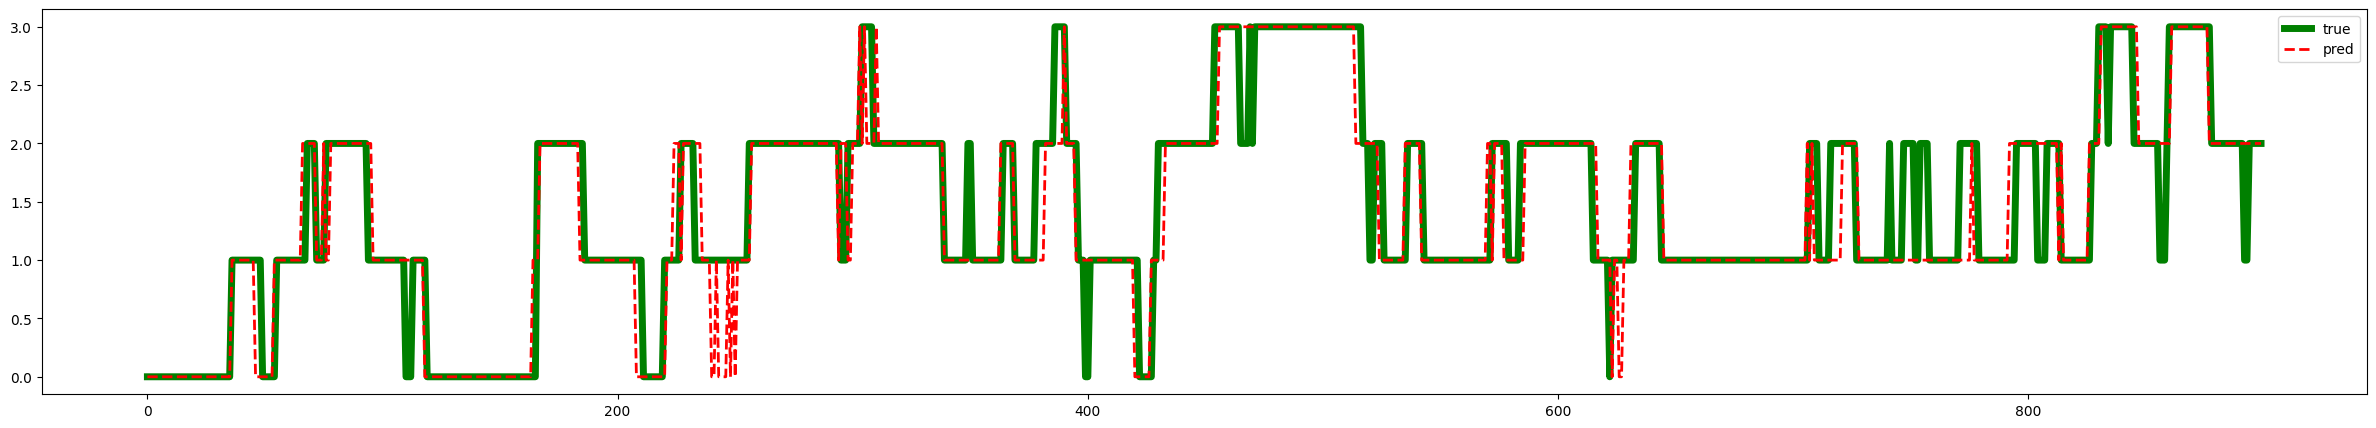

In [34]:
plt.figure(figsize=(30, 5))
plt.plot(y_test_ion_lstm, color='green', label='true', linestyle='solid', linewidth=5)
plt.plot(y_pred_ion, color='red', label='pred', linestyle='dashed', linewidth=2)
# X_test_ion scatter plot
# plt.scatter(range(len(X_test_ion)), X_test_ion, color='green', label='true')
plt.legend()

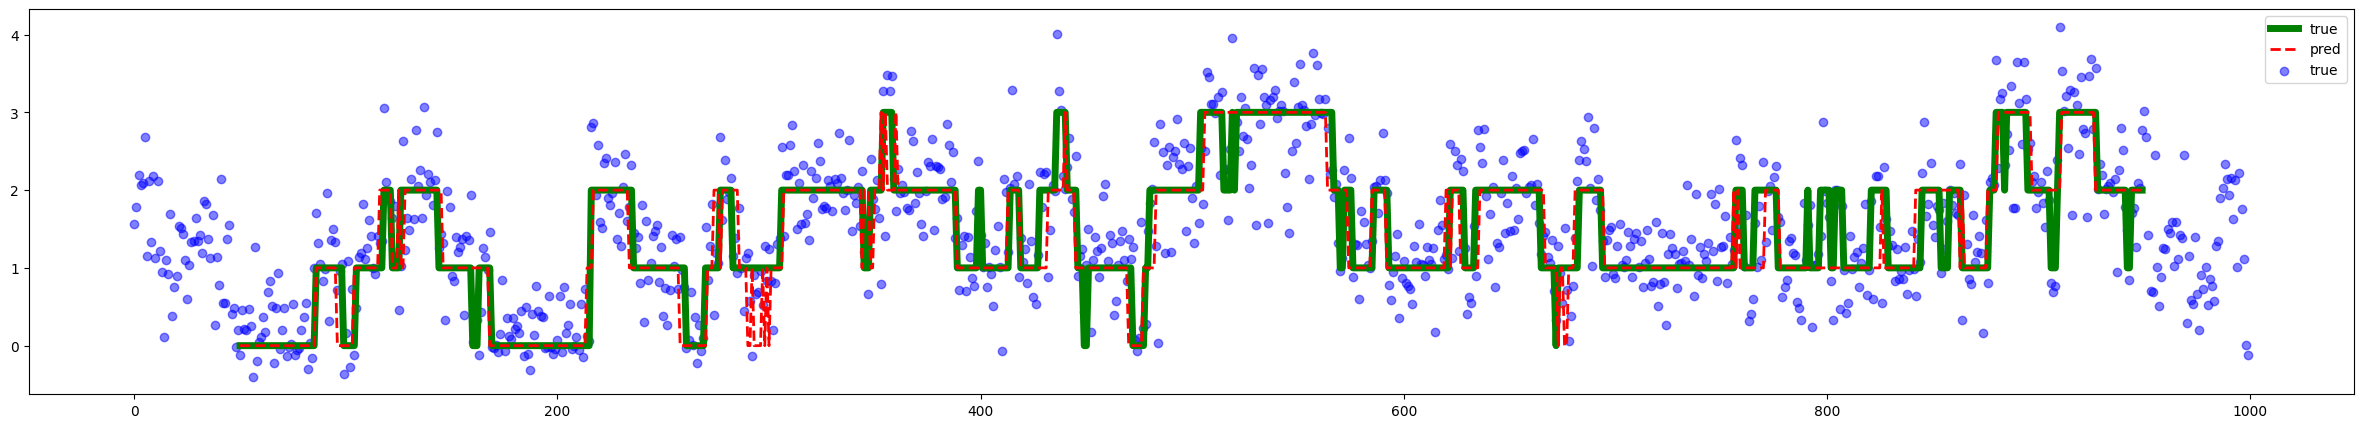

In [40]:
# normalize X_test_ion to be between 2 and 0
X_test_ion = (X_test_ion - np.min(X_test_ion)) / (np.max(X_test_ion) - np.min(X_test_ion)) * 4.5 - 0.4

plt.figure(figsize=(30, 5))
# start from 50
plt.plot(range(50, 50 + len(y_test_ion_lstm)), y_test_ion_lstm, color='green', label='true', linestyle='solid',
         linewidth=5)
# start from 50
plt.plot(range(50, 50 + len(y_pred_ion)), y_pred_ion, color='red', label='pred', linestyle='dashed', linewidth=2)
# X_test_ion scatter plot
plt.scatter(range(len(X_test_ion)), X_test_ion, color='blue', label='true', alpha=0.5)
plt.legend()

## Save the model

In [42]:
# save the model
model.save('models/LSTM_normalized_50points_behind_50points_ahead_classification_with_artificial_data.keras')